# Download Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!unzip "/content/drive/My Drive/Copy of mscoco.zip" -d ./mscoco/

In [3]:
! wget -q "https://drive.google.com/uc?export=download&id=1-3tnHTdDjtMd9O2LgKN2ir3t5KvnqrXI" -O dataset.zip
! unzip dataset.zip

# Loading Data

## vocabulary class

In [4]:
import nltk
from itertools import chain

nltk.download('punkt')
from collections import Counter

def tokenize(corpus):
    """ tokenizes the corpus and returns it as a list of list of tokens
    corpus: Input corpus as a list of sentences (each sentence is a string)
    """
    return [nltk.word_tokenize (c.lower()) for c in corpus]
# print (tokenize(["Hello world"]))

class Vocab:
    def __init__(self, word2id=None):
        """Constructor of Vocab

        word2id: dictionary that maps tokens to their ids.
        """
        self.pad_token = '<PAD>'
        self.end_token = '<END>'
        self.start_token = '<START>'
        self.unk_token = '<UNK>'

        if word2id is None:
            self.word2id = {self.pad_token: 0,
                            self.start_token: 1,
                            self.end_token: 2,
                            self.unk_token: 3}
            self.size = 4
        else:
            self.word2id = word2id
            self.size = len(self.word2id)

        self.id2word = {v: k for (k, v) in self.word2id.items()}

    def build(self, tokenized_corpus, size=None, min_freq=3):
        """Builds the vocab from a tokenized corpus.

        tokenized_corpus: corpus as a list of list of tokens (strings)
        size: Final size of (number of unique tokens in) our vocab
        min_freq: minimum frequency
        """
        tokens2freq = Counter(chain(*tokenized_corpus))  # dict that maps unique tokens to their freqs in the corpus
        
        frequent_tokens = []

        if min_freq is not None:
          # print ("applying min freq")
          tokens2freq = {k: tokens2freq[k] for k in tokens2freq.keys() if tokens2freq[k] > min_freq}

        if size is None:
          frequent_tokens = list (tokens2freq.keys())
          
        else:
          sorted_token2freq = {k: v for k, v in sorted(dict (tokens2freq).items(), key=lambda item: item[1] , reverse=True)}
          # print (sorted_token2freq)
          frequent_tokens = [k for i,k in enumerate (sorted_token2freq.keys()) if i < self.size ]
          
        # adding tokens to the vocab

        for token in frequent_tokens:
            self.add_token(token)
        
    def get_token_by_id(self, t_id: int) -> str:
        """Returns the token with the corresponding id in the vocab.
        If the id is not valid, returns None.

        t_id: token id
        """
        return self.id2word.get(t_id, None)

    def get_id_by_token(self, token: str) -> int:
        """Returns the id of the token in the vocab. If the token does not exist,
        returns the id of <UNK> token.

        token: token (as a string) for which the id should be returned.
        """
        return self.word2id.get(token, self.word2id[self.unk_token])

    def add_token(self, token: str):
        """Adds the token to the vocab's data structures
        token: token as a string
        """
        if not token in self.word2id.keys():
          self.word2id[token] = self.size
          self.id2word[self.size] = token
          self.size += 1
          
    def tokens2ids(self, sents):
        """Convert list of words or list of sentences of tokens 
        into list or list of list of indices.

        sents: input sentences as List[List[str]] (multiple sentences) or List[str]
        (single sentence)
        """
        self.word2id
        if type(sents[0]) == list:
            return [[self.word2id[word] if word in self.word2id.keys() else self.word2id[self.unk_token] for word in sent] for sent in sents]
        else:
            return [self.word2id[word] if word in self.word2id.keys() else self.word2id[self.unk_token] for word in sents]
  
    def to_tensor(self, sent):
        """Converts a sentence as a list of tokens into a tensor of indices.

        sent: a sentence as a list of strings (tokens)
        """
        return torch.tensor (self.tokens2ids(sent) , dtype = torch.long)


    def pad_sents(self, sents):
        """Pads list of sentences according to the longest sentence.

        sents: sentences as a list of list of tokens (strings).
        """
        sents_padded = []
        lengths = [len(v) for v in sents]
        ml = max (lengths)
        sents_padded = [v + [self.pad_token] * (ml - len(v)) for v in sents]
        return sents_padded

    def save(self, path: str):
        """Saves the vocab in a json file.

        path: path to save the vocab in
        """
        with open(path, 'w') as f:
            json.dump(self.word2id, f)

    @staticmethod
    def load(path: str):
        """Loads vocab from a json file.

        path: path to load the vocab from
        """
        with open(path, 'r') as f:
            word2id = json.load(f)

        return Vocab(word2id)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MMWI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## CSV reader function

In [5]:
from PIL import Image, ImageDraw
from tqdm.auto import tqdm
import torch
import torchvision 
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt

def plot_tensor (tensor):
    plt.imshow (tensor.permute([1,2,0]))
    plt.show ()

def plot_box_on_tensor (source_tensor , box):
  source_img = torchvision.transforms.ToPILImage(mode='RGB')(source_tensor)
  x0, y0, W, H = box
  x1, y1 = x0 + W, y0 + H
  draw = ImageDraw.Draw(source_img)
  draw.rectangle([x0,y0,x1,y1], width=3)
  return torchvision.transforms.ToTensor ()(source_img)

def parse_box(box_str):
  a,b,c,d = box_str.split ("]")[0].split ("[")[1].split ()
  return float (a) , float(b), float(c), float(d)

def load_files(csv_name = "dataset.train.csv" , max_limit = None):
  train_set = []
  counter = 0
  print ("loading", csv_name)
  with open ("dataset/" + csv_name) as train_csv_file:
    
    line = next (train_csv_file)
    for line in tqdm (train_csv_file):
      counter += 1
      line = line.split ("\n")[0]
      
      file_id = line.split (",")[0]
      image_name = line.split (",")[1]
      text = (line.split ('"')[1]) if '"' in line else (line.split (',')[2])
      box = parse_box (line.split (",")[-1])
      
      train_set.append ({"image_name":image_name ,"box":box, "text":text, "id":file_id})
      if max_limit is not None and counter == max_limit:
            break
    
    return train_set
  


In [6]:
train_data_set = load_files (csv_name = "dataset.train.csv", max_limit = None)
valid_data_set = load_files (csv_name = "dataset.valid.csv")

train_corpus = [d['text'] for d in train_data_set]

vocab = Vocab()
vocab.build (tokenize (train_corpus), min_freq = 3)
print ("vocab size:", vocab.size)

loading dataset.train.csv



loading dataset.valid.csv



vocab size: 3937


## dataset class

In [7]:
def scale_and_pad(img, new_size = 224):
  min_dim = img.size.index (min(img.size))
  min_size = img.size[min_dim]
  max_dim = 1 - min_dim
  max_size = img.size[max_dim]

  unpadded_size = [new_size, new_size]
  unpadded_size[min_dim] = int (new_size/max_size * min_size)
  if unpadded_size[min_dim] == 0:
        unpadded_size[min_dim] = 1

  resized_image = torchvision.transforms.functional.resize(img, size = [unpadded_size[1] , unpadded_size[0]])

  new_w, new_h = resized_image.size

  pad_top = (new_size - new_h)//2 if new_h < new_size else 0
  pad_bottom = (new_size - new_h - pad_top) if new_h < new_size else 0

  pad_right = (new_size - new_w)//2 if new_w < new_size else 0
  pad_left = (new_size - new_w - pad_right) if new_w < new_size else 0

  pad_value = 0 #int (torchvision.transforms.functional.to_tensor(resized_image).mean().item() * 255)

  img_padded = torchvision.transforms.functional.pad (resized_image, padding = (pad_left, pad_top, pad_right, pad_bottom), fill= pad_value, padding_mode='constant')
#       print (img.size, min_size, unpadded_size, [new_w, new_h] , (pad_left, pad_top, pad_right, pad_bottom), img_padded.size)

  return img_padded

def check_iou(boxA , boxB , th = 0.3):
    x0A, y0A, x1A, y1A = boxA
    x0B, y0B, x1B, y1B = boxB

    sA = (x1A - x0A)*(y1A - y0A)
    sB = (x1B - x0B)*(y1B - y0B)

    x0 = max (x0A, x0B)
    x1 = min (x1A, x1B)

    y0 = max (y0A, y0B)
    y1 = min (y1A, y1B)

    s_inter = (y1-y0) * (x1-x0)
    if (y1-y0) < 0 or (x1-x0) < 0:
        s_inter = 0
    s_union = sA + sB - s_inter
    IoU = s_inter/s_union
#     print ("IOU:" , IoU)
    if IoU > th:
        return False
    else:
        return True

def crop_image(original_image , box):
    x0 , y0, W, H = box
    return torchvision.transforms.functional.crop(original_image, top = int (y0), left = int (x0), height = int (H), width = int (W))
    

class ImageCaptioningDataset(torch.utils.data.Dataset):
    def __init__(self, data_set, vocab, isValid = False):
      self.dataset = data_set
      assert vocab is not None
      self.vocab = vocab
      self.regions = None
      self.negative_box_output = False
      self.isValid = isValid
    
    def cache_region_proposals(self, faster_model = None):
      if self.regions is not None:
            return
      file_name = 'regions_valid.pickle' if self.isValid else 'regions.pickle'
#       print (os.path.isfile('regions.pickle'))
      if os.path.isfile(file_name):
        with open(file_name, 'rb') as f:
          self.regions = torch.load(f)
        return
      if faster_model is None:
        faster_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(DEVICE)
        faster_model = faster_model.to(DEVICE)
        faster_model.eval()
      
      regions = {}
      print ("running faster rcnn on dataset, be patient ...")
      for data in tqdm (self.dataset):
        image_name = data['image_name']
        original_image = Image.open("mscoco/mscoco/" + image_name).convert(mode="RGB")
        original_image_tensor = torchvision.transforms.ToTensor()(original_image)
        with torch.no_grad():
          output = faster_model(original_image_tensor[None].to(DEVICE))
          output = output[0]
          output['boxes'] = output['boxes'].cpu()
          output['labels'] = output['labels'].cpu()
          output['scores'] = output['scores'].cpu()
          regions[image_name] = output
      self.regions = regions
    
      with open(file_name, 'wb') as f:
        torch.save(self.regions, f)            
          
    def enable_comprehension_mode(self): 
        self.negative_box_output = True
        self.cache_region_proposals()
        
    def disable_comprehension_mode(self): 
        self.negative_box_output = False
        self.regions = None
    
    def get_one_candidate_box(self, image_name, positive_box, image_size , score_th = 0.9):
      x0 , y0, W, H = positive_box
      positive_box = [x0, y0, x0+W, y0+H]
      regions = self.regions[image_name]['boxes'][self.regions[image_name]['scores'] > score_th]
#       print (len ( self.regions[image_name]['boxes']) , len(regions))
      IOU_Th = 0.5
      IOU_mask = [check_iou(box, positive_box , th = IOU_Th) for box in regions]
      regions = regions[IOU_mask]
      if len (regions) > 0:
          
          random_num = torch.randint(low=0, high = len (regions) , size = [1]).item()
          negative_box = regions[random_num]
          x0 , y0, x1, y1 = negative_box
      else:
#         print ("faster network failure")
        image_w, image_h = image_size        
        while True:
            x0 = torch.randint (low = 0, high = image_w, size = [1]).item()
            y0 = torch.randint (low = 0, high = image_h, size = [1]).item()
            x1 = torch.randint (low = 0, high = image_w, size = [1]).item()
            y1 = torch.randint (low = 0, high = image_h, size = [1]).item()
            box = [x0,y0,x1,y1]
            if x0 < x1 and y0 < y1 and check_iou(box, positive_box , th = IOU_Th):
                break
#         print ([x0,y0,x1,y1] , positive_box)                
        
      W = x1 - x0
      H = y1 - y0
      negative_box = x0 , y0 , W, H         
      
      return negative_box
        
    def __getitem__(self, index):
      data = self.dataset[index]
      # {"image_name":image_name ,"box":box, "text":text, "id":file_id}
      text = data["text"]
      box = data['box']        
      image_name = data['image_name']
#       print (image_name)
      original_image = Image.open("mscoco/mscoco/" + image_name).convert(mode="RGB")
        
      
      cropped_img = crop_image (original_image, box)

      scaled_img_tensor = torchvision.transforms.ToTensor() (scale_and_pad (original_image))
      scaled_cropped_img_tensor = torchvision.transforms.ToTensor() (scale_and_pad (cropped_img))
      
      original_image_tensor = torchvision.transforms.ToTensor()(original_image)
#       print (scaled_img_tensor.shape, )
    
      original_data = {'image_name':image_name, 'box':box, 'text':text, 'original_img_tensor':original_image_tensor, 'scaled_img_tensor':scaled_img_tensor, 'scaled_cropped_img_tensor':scaled_cropped_img_tensor}
      tokenized_text = ['<START>'] + tokenize([text])[0] + ['<END>']

    
      if self.negative_box_output:
        neg_box = self.get_one_candidate_box(image_name, box , original_image.size)
        cropped_img = crop_image (original_image, neg_box)
        
        neg_scaled_cropped_img_tensor = torchvision.transforms.ToTensor() (scale_and_pad (cropped_img))
        original_data['neg_box'] = neg_box
        
      original_image.close(), cropped_img.close()
      del original_image, cropped_img
      
      if self.negative_box_output:
          return original_data, scaled_img_tensor, scaled_cropped_img_tensor, tokenized_text, neg_scaled_cropped_img_tensor
      else:
          return original_data, scaled_img_tensor, scaled_cropped_img_tensor, tokenized_text

    def __len__(self):        
        return len (self.dataset)

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#fixme
train_dataset = ImageCaptioningDataset(train_data_set, vocab = vocab, isValid = False)
valid_dataset = ImageCaptioningDataset(valid_data_set, vocab = vocab, isValid = True)

# train_dataset, _ = torch.utils.data.random_split(train_dataset, [8, len (train_dataset) - 8])

def collate_fn(batch):
  original_datas = [b[0] for b in batch]
  scaled_img_tensors = torch.stack ([b[1] for b in batch])
  scaled_cropped_img_tensors = torch.stack ([b[2] for b in batch])
  tokenized_text = [b[3] for b in batch]
  target_tensors = vocab.to_tensor(vocab.pad_sents(tokenized_text)).transpose (0,1)
      
  if len(batch[0]) == 5:
    neg_scaled_cropped_img_tensors = torch.stack ([b[4] for b in batch])
    return original_datas, scaled_img_tensors, scaled_cropped_img_tensors, target_tensors, neg_scaled_cropped_img_tensors
  else:
    return original_datas, scaled_img_tensors, scaled_cropped_img_tensors, target_tensors



train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers = 0, shuffle=True , collate_fn = collate_fn, drop_last = True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, num_workers = 0, shuffle=False, collate_fn = collate_fn, drop_last = False)


## testing captioning mode

Text: sheep in extreme right sside
Text tensor: tensor([   1,  883,   18, 2312,   15,    3,    2,    0,    0,    0,    0,    0,
           0,    0,    0])
Original image:


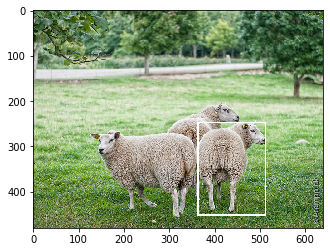

scaled image:


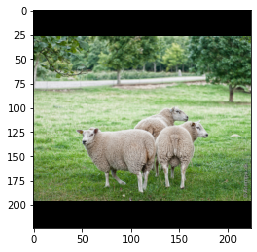

scaled crop:


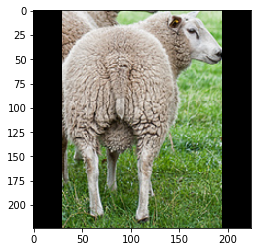

In [203]:
train_dataset.disable_comprehension_mode()
valid_dataset.disable_comprehension_mode()

counter = 0 
for batch in train_dataloader:
  original_datas, scaled_img_tensors, scaled_cropped_img_tensors, target_tensors = batch
  break

original_img = original_datas[0]['original_img_tensor']
box = original_datas[0]['box']
text = original_datas[0]['text']

print ("Text:" , text)
print ("Text tensor:" , target_tensors[:,0])
print ("Original image:")
plot_tensor(plot_box_on_tensor(original_img, box))
print ("scaled image:")
plot_tensor(scaled_img_tensors[0])
print ("scaled crop:")
plot_tensor(scaled_cropped_img_tensors[0])


## testing comprehension mode

Text: the couch that is between the tree and the end table
Text tensor: tensor([  1,  10,  80, 150,  84, 119,  10, 128,  46,  10, 265, 142,   2,   0,
          0,   0,   0])
Original image + postitive and negative boxes:


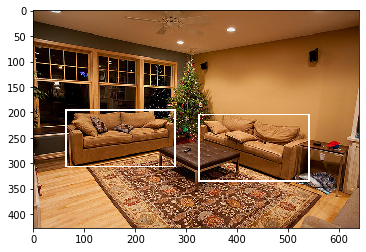


scaled image:


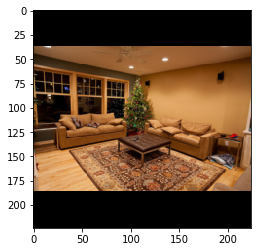

scaled crop:


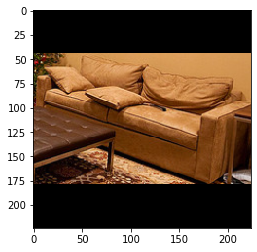

negative scaled crop:


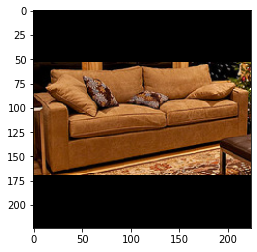

In [11]:
train_dataset.enable_comprehension_mode()
valid_dataset.enable_comprehension_mode()

counter = 0 
for batch in tqdm (train_dataloader , total = len (train_dataloader)):
  original_datas, scaled_img_tensors, scaled_cropped_img_tensors, target_tensors, negative_scaled_cropped_img_tensors= batch
  break

original_img = original_datas[0]['original_img_tensor']
box = original_datas[0]['box']
neg_box = original_datas[0]['neg_box']
text = original_datas[0]['text']

print ("Text:" , text)
print ("Text tensor:" , target_tensors[:,0])
print ("Original image + postitive and negative boxes:")
plot_tensor(plot_box_on_tensor(plot_box_on_tensor(original_img, neg_box), box))
print ("scaled image:")
plot_tensor(scaled_img_tensors[0])
print ("scaled crop:")
plot_tensor(scaled_cropped_img_tensors[0])
print ("negative scaled crop:")
plot_tensor(negative_scaled_cropped_img_tensors[0])


# Model

## Attention Model

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models

#overwriting forward function
class CustomResnet(nn.Module):
    def forward(self, x):
        resnet = self.resnet
        x = resnet.conv1(x)
        x = resnet.bn1(x)
        x = resnet.relu(x)
        x = resnet.maxpool(x)

        x = resnet.layer1(x)
        x = resnet.layer2(x)
        x = resnet.layer3(x)
        x_middle = resnet.layer4(x)

        x = resnet.avgpool(x_middle)
        x = torch.flatten(x, 1)
        x = resnet.fc(x)

        return x, self.conv_last (x_middle)
    
    def __init__(self):
        super(CustomResnet, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.resnet = resnet
        self.conv_last = nn.Conv2d (2048 , 512, (1,1))
#         del self.resnet.fc, self.resnet.avgpool

#         for a in self.resnet.parameters():
#           a.requires_grad_(False)
        

class ImageCaptionerModel_attn(nn.Module):
    def get_feature_extractor (self, input_image_size):
        self.resnet = CustomResnet()
        # models.vgg19_bn(pretrained=True).features
        feature_extracotor = self.resnet
        x, x_mid = feature_extracotor (torch.rand (*[1, 3, 224 , 224]))

        features_size = x_mid[0].shape
        
        return feature_extracotor, features_size


    def __init__(self, vocab = None, input_image_size = 224):
        super(ImageCaptionerModel_attn, self).__init__()
        
        self.cnn_feature_extractor, features_size = self.get_feature_extractor (input_image_size)
        # print ("Features size= ", features_size)

        
        self.HW = features_size[1] * features_size[2]
        self.C = features_size[0]
        self.hidden_size = self.C
        self.embeding_size = 512
        self.encoder_output_size = 2000
        
        self.vocab = vocab

        self.embedding = torch.nn.Embedding(num_embeddings = vocab.size, embedding_dim = self.embeding_size, padding_idx=vocab.word2id[vocab.pad_token])
        self.rnn = nn.GRUCell (input_size = 2 * self.C + self.embeding_size, hidden_size=self.hidden_size)
        self.bridge = nn.Linear(self.encoder_output_size , self.hidden_size , bias = True)
        self.output_projection = nn.Linear (self.hidden_size, vocab.size, bias=False)
        self.attn_combine = torch.nn.Linear( 2 * self.C + self.hidden_size , self.hidden_size, bias=False)
        self.dropout = torch.nn.Dropout (0.3)
    
    
    
    def initialize_hiddens(self, context_features_flat, crop_features_flat):
      batch_size = context_features_flat.shape[0]
      init_hidden_states = self.dropout (self.bridge (torch.cat ([context_features_flat, crop_features_flat], dim = -1)))
      # print ("init hiddens :", init_hidden_states.shape)
      return init_hidden_states



    def get_logits(self, context_features_flat, crop_features_flat, context_features, crop_features, sentences, init_hidden_states = None):
      batch_size = context_features.shape[0]
    
      if init_hidden_states is None:
        init_hidden_states = self.initialize_hiddens(context_features_flat, crop_features_flat)
      dec_state = init_hidden_states
      
      combined_output_prev = torch.cat ([context_features.mean(-1), crop_features.mean(-1)] , dim = -1)  
      
      embedded_sents = self.embedding (sentences)
      # print ("combined_output_prev.shape" , combined_output_prev.shape)
      combined_outputs = []
    
      for t, y_t in enumerate (embedded_sents):
#         print ("y_t:" , y_t.shape)
        ybar_t = torch.cat ((y_t, combined_output_prev) , dim = -1)
        dec_state , combined_output_prev = self.step(ybar_t , dec_state, context_features, crop_features)
        combined_outputs.append (dec_state)

      combined_outputs = torch.stack (combined_outputs)
      logits = self.output_projection (combined_outputs)
      return logits, dec_state

    def forward(self, x):
      DEVICE = next (self.parameters()).device
      
      context_image_tensor = x[0].to(DEVICE)
      cropped_image_tensor = x[1].to(DEVICE)
      full_sentences = x[2].to(DEVICE)

      sentences = full_sentences[:-1] 
      
      B = cropped_image_tensor.shape[0]

      context_features_flat, context_features = self.cnn_feature_extractor(context_image_tensor)
      crop_features_flat, crop_features = self.cnn_feature_extractor(cropped_image_tensor)
      
      context_features = context_features.reshape (B, self.C, self.HW)
      crop_features = crop_features.reshape (B, self.C, self.HW)
        
      logits, _ = self.get_logits(context_features_flat, crop_features_flat, context_features, crop_features, sentences)

      sent_mask = (full_sentences != self.vocab.word2id[self.vocab.pad_token]).float()

      log_probs = F.log_softmax(logits, dim=-1)
      # Compute log probability of generating true target words
      tgt_gold_words_log_prob = torch.gather(log_probs, index=full_sentences[1:].unsqueeze(-1), dim=-1).squeeze(-1) * sent_mask[1:]

      # sum scores across different time steps of sequences (i.e. computing log probability of the sequences)
      scores = tgt_gold_words_log_prob.sum(dim=0)
      
      return scores
     

    def step(self, ybar_t, dec_state, context_features, crop_features):
        
        dec_state_t = self.rnn(ybar_t,dec_state)
        
#         print ("dec_state_t:", dec_state_t.shape)
#         print ("context_features:", context_features.shape)
#         print ("crop_features:", crop_features.shape)

        context_attn_scores_t = torch.bmm (dec_state_t[:,None,:], context_features)
        crop_attn_scores_t    = torch.bmm (dec_state_t[:,None,:], crop_features)

        context_attn_dist = torch.nn.Softmax(dim=-1)(context_attn_scores_t)
        crop_attn_dist    = torch.nn.Softmax(dim=-1)(crop_attn_scores_t)

        # print ("context_attn_dist:", context_attn_dist.shape)
        # print ("crop_attn_dist:", crop_attn_dist.shape)

        attended_context_features = (context_features * context_attn_dist).sum(dim = -1)
        attended_crop_features    = (crop_features    * crop_attn_dist).sum(dim = -1)
        
        # print ("attended_context_features:", attended_context_features.shape)
        # print ("attended_crop_features:", attended_crop_features.shape)
        
        concated_tensor = torch.cat((attended_context_features, attended_crop_features) , dim = -1)
        return dec_state_t, concated_tensor
    
    def decode_beam(self, beam, context_features_flat, crop_features_flat, context_features, crop_features, k):
        hidden_state = beam['last_hidden']
        word = torch.tensor ([beam['words'][-1]])
        sentences = word[None].to(DEVICE)
#         print ("Beam2:", context_features[0,:5])
        logits, _ = self.get_logits(context_features_flat, crop_features_flat, context_features, crop_features, sentences, hidden_state)        

#         print ("beam logits", logits[:,:,:3], hidden_state[0,0,:3])
#         print (1/0)
        probs = logits.softmax(dim=-1)
        probs, idxs = torch.topk (probs, k)
        probs = probs.reshape([k])
        idxs = idxs.reshape([k])
        
        res = []
        for i in range(probs.shape[0]):
            res.append({"last_hidden":hidden_state, "prob": probs[i].item() * beam['prob'] , "words": beam['words']+[idxs[i].item()]})
        return res

    def BeamDecode (self, x, max_length = 10, k = 5):
      DEVICE = next (self.parameters()).device
      context_image_tensor = x[0].to(DEVICE)
      cropped_image_tensor = x[1].to(DEVICE)        
      B = cropped_image_tensor.shape[0]
        
      context_features_flat, context_features = self.cnn_feature_extractor(context_image_tensor)
      crop_features_flat, crop_features = self.cnn_feature_extractor(cropped_image_tensor)
      
      context_features = context_features.reshape (B, self.C, self.HW)
      crop_features = crop_features.reshape (B, self.C, self.HW)
        
      word = self.vocab.to_tensor([self.vocab.start_token]).item()
      
      beams_queue = [{"words": [word], "prob": 1, "last_hidden": None}]
      completed_beams = []
      beam_size = k
      
      for i in range (max_length):
        new_beams_queue = []
        for beam in beams_queue:
            new_beams_queue += self.decode_beam (beam, context_features_flat, crop_features_flat, context_features, crop_features, k)
        
        beams_queue = sorted(new_beams_queue, key=lambda x: x['prob'], reverse=True)[:beam_size]
        next_beams_queue = []
        for j in range(len(beams_queue)):
          if not (beams_queue[j]['words'][-1] == self.vocab.to_tensor([self.vocab.end_token]).item()):
            next_beams_queue.append (beams_queue[j])
          else:
            beam_size -= 1
            completed_beams.append(beams_queue[j])
            
        beams_queue = next_beams_queue
            
        if (beam_size <= 0):
            break
      
    
      NO_END_FLAG = False
      if (len(completed_beams) == 0):
        completed_beams = beams_queue
        NO_END_FLAG = True
        
      sentence_list = max(completed_beams, key=lambda x: x['prob'])['words']      
#       beam_probs = torch.tensor ([completed_beams[t]['prob'] for t in range (len (completed_beams)) if t < 4])    
#       beam_candidates = torch.distributions.categorical.Categorical(logits=beam_probs)
#       sentence_list = completed_beams[beam_candidates.sample().item()]['words']
      
      sentence_list = sentence_list[1:] #removing start

      if not NO_END_FLAG:
        sentence_list = sentence_list[:-1] #removing stop token
      return [vocab.get_token_by_id(word) for word in sentence_list]


DEBUG_MODEL = False
if DEBUG_MODEL:
  DEVICE = 'cpu'
  model = ImageCaptionerModel_attn(vocab).to(DEVICE)
  a = model ([torch.rand (*[2, 3, 224 , 224])]*2 + [torch.randint(low = 0, high = vocab.size, size = [10, 2])])
  x = [torch.rand (*[1, 3, 224 , 224])]*2
  sentence2 = model.BeamDecode   (x)
  sentence3 = model.BeamDecode   (x , k = 1)
  print (a.shape)
  print (" ".join(sentence2))
  print (" ".join(sentence3))

    



## LSTM model

In [16]:
class ImageCaptionerModel(nn.Module):
    def __init__(self, Vocab = None, input_image_size = 224):
        super(ImageCaptionerModel, self).__init__()
        
        
#         self.cnn_feature_extractor = models.vgg19_bn(pretrained=True)
        self.cnn_feature_extractor = models.resnet50(pretrained=True)
#         for a in self.cnn_feature_extractor.parameters():
#             a.requires_grad_(False)

        self.embeding_size = 512
        self.hidden_size = 512
        self.vocab = vocab
        self.input_size = 2000
        self.embedding = torch.nn.Embedding(num_embeddings = vocab.size, embedding_dim = self.embeding_size, padding_idx=vocab.word2id[vocab.pad_token])
        self.rnn = nn.LSTM(input_size= self.embeding_size + self.input_size, hidden_size = self.hidden_size, num_layers = 1, bias = True, )
        self.output_projection = nn.Linear (self.hidden_size, vocab.size, bias=False)
        self.dropout = torch.nn.Dropout (0.1)
        self.bridge = nn.Linear (self.input_size , self.hidden_size , bias = True)
        
    def initialize_hiddens(self, context_features, crop_features):
        
      batch_size = context_features.shape[0]
      init_hidden_states = [torch.zeros ([1,batch_size, self.hidden_size] , requires_grad = False).to(DEVICE),
                                  torch.zeros ([1,batch_size, self.hidden_size] , requires_grad = False).to(DEVICE)]      
      
      init_hidden_states[0] = self.dropout (self.bridge (torch.cat ([context_features, crop_features], dim = 1)[None]))
      return init_hidden_states
        
    def get_logits(self, context_features, crop_features, sentences, init_hidden_states = None ):  
      batch_size = context_features.shape[0]
    
      if init_hidden_states is None:
        init_hidden_states = self.initialize_hiddens(context_features, crop_features)

      embedded_sents = self.embedding (sentences)
      rnn_input = torch.cat([torch.cat ([context_features, crop_features], dim = 1)[None].expand(embedded_sents.shape[0],batch_size,crop_features.shape[-1] + context_features.shape[-1]),
                      embedded_sents] , dim = -1)      
    
      output, hiddens = self.rnn(rnn_input, init_hidden_states)
      logits = self.output_projection (output)
      return logits, hiddens

    def forward(self, x):
      DEVICE = next (self.parameters()).device        
      context_image_tensor = x[0].to(DEVICE)
      cropped_image_tensor = x[1].to(DEVICE)
      full_sentences = x[2].to(DEVICE)         
        
      context_features = self.cnn_feature_extractor(context_image_tensor)
      crop_features = self.cnn_feature_extractor(cropped_image_tensor)   
        
      sentences = full_sentences[:-1] 
      logits, _ = self.get_logits(context_features, crop_features, sentences)
    
      sent_mask = (full_sentences != self.vocab.word2id[self.vocab.pad_token]).float()

      log_probs = F.log_softmax(logits, dim=-1)
      # Compute log probability of generating true target words
      tgt_gold_words_log_prob = torch.gather(log_probs, index=full_sentences[1:].unsqueeze(-1), dim=-1).squeeze(-1) * sent_mask[1:]

      # sum scores across different time steps of sequences (i.e. computing log probability of the sequences)
      scores = tgt_gold_words_log_prob.sum(dim=0)
      
      return scores
 
    
    
    def GreedyDecode(self, x, max_length = 10, temperature = 1):
      DEVICE = next (self.parameters()).device        
      context_image_tensor = x[0].to(DEVICE)
      cropped_image_tensor = x[1].to(DEVICE)        
      
      context_features = self.cnn_feature_extractor(context_image_tensor)
      crop_features = self.cnn_feature_extractor(cropped_image_tensor)  
      print ("Greedy:", context_features[0,:5])
      hidden_state = None  

      word = self.vocab.to_tensor([self.vocab.start_token])
      words = []
      for t in range (max_length):
          sentences = word[None].to(DEVICE) #adding time and batch dims
          logits, hidden_state = self.get_logits(context_features, crop_features, sentences, hidden_state)
          dist = torch.distributions.categorical.Categorical(probs=None, logits=logits[0,0]/temperature, validate_args=None)
#           print ("greedy logits", logits[:,:,:3], hidden_state[0,0,:3])
          word = torch.argmax (logits).item() #dist.sample().item()
          if self.vocab.get_token_by_id(word) == self.vocab.end_token:
            break
            
          words.append (vocab.get_token_by_id(word))
#           print (word, vocab.get_token_by_id(word))
          word = torch.tensor ([word])

            
      return words

    def decode_beam(self, beam, context_features, crop_features, k):
        hidden_state = beam['last_hidden']
        word = torch.tensor ([beam['words'][-1]])
        sentences = word[None].to(DEVICE)
#         print ("Beam2:", context_features[0,:5])
        
        logits, hidden_state = self.get_logits(context_features, crop_features, sentences, hidden_state)
#         print ("beam logits", logits[:,:,:3], hidden_state[0,0,:3])
#         print (1/0)
        probs = logits.softmax(dim=-1)
        probs, idxs = torch.topk (probs, k)
        probs = probs.reshape([k])
        idxs = idxs.reshape([k])
        
        res = []
        for i in range(probs.shape[0]):
            res.append({"last_hidden":hidden_state, "prob": probs[i].item() * beam['prob'] , "words": beam['words']+[idxs[i].item()]})
        return res

    def BeamDecode (self, x, max_length = 10, k = 5):
      DEVICE = next (self.parameters()).device
      context_image_tensor = x[0].to(DEVICE)
      cropped_image_tensor = x[1].to(DEVICE)        
        
      context_features = self.cnn_feature_extractor(context_image_tensor)
      crop_features = self.cnn_feature_extractor(cropped_image_tensor)  
#       print ("Beam1:", context_features[0,:5])
      word = self.vocab.to_tensor([self.vocab.start_token]).item()
      
      beams_queue = [{"words": [word], "prob": 1, "last_hidden": None}]
      completed_beams = []
      beam_size = k
      
      for i in range (max_length):
        new_beams_queue = []
        for beam in beams_queue:
            new_beams_queue += self.decode_beam (beam, context_features, crop_features, k)
        
        beams_queue = sorted(new_beams_queue, key=lambda x: x['prob'], reverse=True)[:beam_size]
        next_beams_queue = []
        for j in range(len(beams_queue)):
          if not (beams_queue[j]['words'][-1] == self.vocab.to_tensor([self.vocab.end_token]).item()):
            next_beams_queue.append (beams_queue[j])
          else:
            beam_size -= 1
            completed_beams.append(beams_queue[j])
            
        beams_queue = next_beams_queue
            
        if (beam_size <= 0):
            break
      
    
      NO_END_FLAG = False
      if (len(completed_beams) == 0):
        completed_beams = beams_queue
        NO_END_FLAG = True
        
      sentence_list = max(completed_beams, key=lambda x: x['prob'])['words']      
#       beam_probs = torch.tensor ([completed_beams[t]['prob'] for t in range (len (completed_beams)) if t < 4])    
#       beam_candidates = torch.distributions.categorical.Categorical(logits=beam_probs)
#       sentence_list = completed_beams[beam_candidates.sample().item()]['words']
      
      sentence_list = sentence_list[1:] #removing start

      if not NO_END_FLAG:
        sentence_list = sentence_list[:-1] #removing stop token
      return [vocab.get_token_by_id(word) for word in sentence_list]

DEBUG_MODEL = False
if DEBUG_MODEL:
  DEVICE = 'cpu'
  with torch.no_grad():
      model = ImageCaptionerModel(Vocab = vocab).to(DEVICE)
      a = model ([torch.rand (*[2, 3, 224 , 224])]*2 + [torch.randint(low = 0, high = vocab.size, size = [10, 2])])
      x = [torch.rand (*[1, 3, 224 , 224])]*2
      sentence1 = model.GreedyDecode (x)
      sentence2 = model.BeamDecode   (x)
      sentence3 = model.BeamDecode   (x , k = 1)
      print (a.shape)
      print (" ".join(sentence1))
      print (" ".join(sentence2))
      print (" ".join(sentence3))

## GRU model

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ImageCaptionerModel_GRU(nn.Module):
    def __init__(self, Vocab = None, input_image_size = 224):
        super(ImageCaptionerModel_GRU, self).__init__()
        
        
#         self.cnn_feature_extractor = models.vgg19_bn(pretrained=True)
        self.cnn_feature_extractor = models.resnet50(pretrained=True)
#         for a in self.cnn_feature_extractor.parameters():
#             a.requires_grad_(False)

        self.embeding_size = 512
        self.hidden_size = 512
        self.vocab = vocab
        self.input_size = 2000
        self.embedding = torch.nn.Embedding(num_embeddings = vocab.size, embedding_dim = self.embeding_size, padding_idx=vocab.word2id[vocab.pad_token])
        self.rnn = nn.GRU(input_size=self.embeding_size + self.input_size, hidden_size=self.hidden_size,num_layers=1, batch_first=False, bidirectional=False)

        self.output_projection = nn.Linear (self.hidden_size, vocab.size, bias=False)
        self.dropout = torch.nn.Dropout (0.4)
        self.bridge = nn.Linear (self.input_size , self.hidden_size , bias = True)
        
    def initialize_hiddens(self, context_features, crop_features):
        
      batch_size = context_features.shape[0]
      init_hidden_states = self.bridge (torch.cat ([context_features, crop_features], dim = 1)[None])
      return init_hidden_states
        
    def get_logits(self, context_features, crop_features, sentences, init_hidden_states = None ):
      batch_size = crop_features.shape[0]
    
      if init_hidden_states is None:
        init_hidden_states = self.initialize_hiddens(context_features, crop_features)

      embedded_sents = self.embedding (sentences)
      rnn_input = torch.cat([torch.cat ([context_features, crop_features], dim = 1)[None].expand(embedded_sents.shape[0],batch_size,crop_features.shape[-1] + context_features.shape[-1]),
                      embedded_sents] , dim = -1)      
      hiddens, last_hidden = self.rnn(rnn_input, init_hidden_states)
      logits = self.output_projection (hiddens)
      
      return logits, last_hidden

    def forward(self, x):
      DEVICE = next (self.parameters()).device        
      context_image_tensor = x[0].to(DEVICE)
      cropped_image_tensor = x[1].to(DEVICE)
      full_sentences = x[2].to(DEVICE)         
      context_features = self.cnn_feature_extractor(context_image_tensor)
      crop_features = self.cnn_feature_extractor(cropped_image_tensor)  
        
      sentences = full_sentences[:-1] 
      logits, _ = self.get_logits(context_features, crop_features, sentences)
    
      sent_mask = (full_sentences != self.vocab.word2id[self.vocab.pad_token]).float()

      log_probs = F.log_softmax(logits, dim=-1)
      # Compute log probability of generating true target words
      tgt_gold_words_log_prob = torch.gather(log_probs, index=full_sentences[1:].unsqueeze(-1), dim=-1).squeeze(-1) * sent_mask[1:]

      # sum scores across different time steps of sequences (i.e. computing log probability of the sequences)
      scores = tgt_gold_words_log_prob.sum(dim=0)
      
      return scores
    
    
    def GreedyDecode(self, x, max_length = 10, temperature = 1):
      DEVICE = next (self.parameters()).device
      context_image_tensor = x[0].to(DEVICE)
      cropped_image_tensor = x[1].to(DEVICE)        
      
      context_features = self.cnn_feature_extractor(context_image_tensor)
      crop_features = self.cnn_feature_extractor(cropped_image_tensor)  
      print ("Greedy:", context_features[0,:5])
      hidden_state = None  

      word = self.vocab.to_tensor([self.vocab.start_token])
      words = []
      for t in range (max_length):
          sentences = word[None].to(DEVICE) #adding time and batch dims
          logits, hidden_state = self.get_logits(context_features, crop_features, sentences, hidden_state)
          dist = torch.distributions.categorical.Categorical(probs=None, logits=logits[0,0]/temperature, validate_args=None)
#           print ("greedy logits", logits[:,:,:3], hidden_state[0,0,:3])
          word = torch.argmax (logits).item() #dist.sample().item()
          if self.vocab.get_token_by_id(word) == self.vocab.end_token:
            break
            
          words.append (vocab.get_token_by_id(word))
#           print (word, vocab.get_token_by_id(word))
          word = torch.tensor ([word])

            
      return words

    def decode_beam(self, beam, context_features, crop_features, k):
        hidden_state = beam['last_hidden']
        word = torch.tensor ([beam['words'][-1]])
        sentences = word[None].to(DEVICE)
#         print ("Beam2:", context_features[0,:5])
        
        logits, hidden_state = self.get_logits(context_features, crop_features, sentences, hidden_state)
#         print ("beam logits", logits[:,:,:3], hidden_state[0,0,:3])
#         print (1/0)
        probs = logits.softmax(dim=-1)
        probs, idxs = torch.topk (probs, k)
        probs = probs.reshape([k])
        idxs = idxs.reshape([k])
        
        res = []
        for i in range(probs.shape[0]):
            res.append({"last_hidden":hidden_state, "prob": probs[i].item() * beam['prob'] , "words": beam['words']+[idxs[i].item()]})
        return res

    def BeamDecode (self, x, max_length = 10, k = 5):
      DEVICE = next (self.parameters()).device
      context_image_tensor = x[0].to(DEVICE)
      cropped_image_tensor = x[1].to(DEVICE)        
        
      context_features = self.cnn_feature_extractor(context_image_tensor)
      crop_features = self.cnn_feature_extractor(cropped_image_tensor)  
      word = self.vocab.to_tensor([self.vocab.start_token]).item()
      
      beams_queue = [{"words": [word], "prob": 1, "last_hidden": None}]
      completed_beams = []
      beam_size = k
      
      for i in range (max_length):
        new_beams_queue = []
        for beam in beams_queue:
            new_beams_queue += self.decode_beam (beam, context_features, crop_features, k)
        
        beams_queue = sorted(new_beams_queue, key=lambda x: x['prob'], reverse=True)[:beam_size]
        
        for j in range(len(beams_queue)):
          if (beams_queue[j]['words'][-1] == self.vocab.to_tensor([self.vocab.end_token]).item()):
            beam_size -= 1
            completed_beams.append(beams_queue[j])
            beams_queue.pop(j)
            
        if (beam_size <= 0):
            break
      
    
      NO_END_FLAG = False
      if (len(completed_beams) == 0):
        completed_beams = beams_queue
        NO_END_FLAG = True
      
      sentence_list = max(completed_beams, key=lambda x: x['prob'])['words']
      sentence_list = sentence_list[1:] #removing start

      if not NO_END_FLAG:
        sentence_list = sentence_list[:-1] #removing stop token
      return [vocab.get_token_by_id(word) for word in sentence_list]


DEBUG_MODEL = False
if DEBUG_MODEL:
  DEVICE = 'cpu'
  with torch.no_grad():
      model = ImageCaptionerModel(Vocab = vocab).to(DEVICE)
      a = model ([torch.rand (*[2, 3, 224 , 224])]*2 + [torch.randint(low = 0, high = vocab.size, size = [10, 2])])
      x = [torch.rand (*[1, 3, 224 , 224])]*2
      sentence1 = model.GreedyDecode (x)
      sentence2 = model.BeamDecode   (x)
      sentence3 = model.BeamDecode   (x , k = 1)
      print (a.shape)
      print (" ".join(sentence1))
      print (" ".join(sentence2))
      print (" ".join(sentence3))




## scheduler , optimizer

In [18]:
import numpy as np
DEVICE = 'cuda'

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

model = ImageCaptionerModel(vocab, 224).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, dampening=0, weight_decay=5e-5, nesterov=True)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 5, T_mult = 1, eta_min=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.1, last_epoch=-1)

# number of trainable parameters
params = sum([np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters())])

print ("Number of trainable parameters:", params)


Number of trainable parameters: 36810280


# Image Captioning Training

In [142]:
train_dataset.disable_comprehension_mode()
valid_dataset.disable_comprehension_mode()

## Train Test functions

In [154]:
from IPython.display import clear_output

def demo_one_data(model, scaled_img_tensor, scaled_cropped_img_tensor, original_data):    
    model.eval()
    with torch.no_grad():
        sent = model.BeamDecode([scaled_img_tensor[None], scaled_cropped_img_tensor[None]], k = 5 , max_length = 15)
    print ("ground truth:", original_data['text'])
    print ("decoded:", " ".join (sent))
    plot_tensor (scaled_cropped_img_tensor)
    plot_tensor (scaled_img_tensor)


def train_one_epoch(dataloader, model, optimizer, loss_tracker):
    losses = []

    torch.cuda.empty_cache()
    
    loss_avg = 0
    n_batches = 0
    
    import time
    t = time.time()
    for i, batch in tqdm (enumerate (dataloader) , total = len (dataloader)):
      model.train()
      original_datas, scaled_img_tensors, scaled_cropped_img_tensors, tokenized_texts = batch
      batch_size = len (scaled_img_tensors)
      optimizer.zero_grad()
      output = model([scaled_img_tensors, scaled_cropped_img_tensors, tokenized_texts])
      loss = -output.sum()/batch_size
      loss.backward()
      optimizer.step()
        
      loss_avg = (loss_avg * n_batches + loss.item() * batch_size) / (batch_size + n_batches)
      n_batches += batch_size
        
      if i% 50 == 0:
        print ("     " , i,"average loss:" , loss_avg, "lr:", get_lr(optimizer))
        losses.append (loss_avg)
#         clear_output(True)
#         loss_avg, n_batches = 0, 0
#         plt.plot (losses)
#         plt.show()
    
      del output, loss,
      torch.cuda.empty_cache()
    
#     demo_one_data(model, scaled_img_tensors[0], scaled_cropped_img_tensors[0], original_datas[0])        
    loss_tracker.append (loss_avg)    


def valid_one_epoch(dataloader, model, loss_tracker):
    losses = []
    torch.cuda.empty_cache()
    
    loss_avg = 0
    n_batches = 0
    
    
    for i, batch in tqdm (enumerate (dataloader) , total = len (dataloader)):
      model.eval()
      original_datas, scaled_img_tensors, scaled_cropped_img_tensors, tokenized_texts = batch
      batch_size = len (scaled_img_tensors)
      with torch.no_grad():
        output = model([scaled_img_tensors, scaled_cropped_img_tensors, tokenized_texts])
        loss = -output.sum()/batch_size
        loss_avg = (loss_avg * n_batches + loss.item() * batch_size) / (batch_size + n_batches)
        n_batches += batch_size

      if i% 50 == 0:
        print ("    " , i,"average loss:" , loss_avg, "lr:", get_lr(optimizer))
        losses.append (loss_avg)
#         loss_avg, n_batches = 0, 0
        
#         plt.plot (losses)
#         plt.show()
          
        
      del output, loss,
      torch.cuda.empty_cache()
    
#     demo_one_data(model, scaled_img_tensors[0], scaled_cropped_img_tensors[0], original_datas[0])
    loss_tracker.append (loss_avg)      


def evalute (dataloader, model):
    decoded_sents = []
    torch.cuda.empty_cache()    
    model.eval()
    for i, batch in tqdm (enumerate (dataloader) , total = len (dataloader)):  
      original_datas, scaled_img_tensors, scaled_cropped_img_tensors, tokenized_texts = batch
      batch_size = len (scaled_img_tensors)
      with torch.no_grad():
          for scaled_img_tensor, scaled_cropped_img_tensor in zip(*[scaled_img_tensors, scaled_cropped_img_tensors]) :
            sent = model.BeamDecode([scaled_img_tensor[None], scaled_cropped_img_tensor[None]], k = 3, max_length = 20)
            decoded_sents.append (" ".join (sent))

    new_decoded_sents = []
    for a in decoded_sents:
        if a[-1] == '.':
            new_decoded_sents.append (a[:-2])
        else:
            new_decoded_sents.append (a)            

    return new_decoded_sents


## train loop

In [103]:
torch.cuda.empty_cache()
train_loss_tracker = []
valid_loss_tracker = []

epochs = 7
model_path = "Model_long_epochs.pth"


      0 average loss: 62.6517219543457 lr: 0.01
      50 average loss: 55.687148823457605 lr: 0.01
      100 average loss: 50.72408596831975 lr: 0.01
      150 average loss: 48.4663615195167 lr: 0.01
      200 average loss: 46.74980914177586 lr: 0.01
      250 average loss: 45.65686883964386 lr: 0.01
      300 average loss: 44.6665075688663 lr: 0.01
      350 average loss: 43.76717443004292 lr: 0.01
      400 average loss: 43.02980631783121 lr: 0.01
      450 average loss: 42.453974332619126 lr: 0.01
      500 average loss: 41.98418659507157 lr: 0.01
      550 average loss: 41.53136658019466 lr: 0.01
      600 average loss: 41.06575590441511 lr: 0.01
      650 average loss: 40.74493996522028 lr: 0.01
      700 average loss: 40.40471166210747 lr: 0.01
      750 average loss: 40.14246505046496 lr: 0.01
      800 average loss: 39.89170355683707 lr: 0.01
      850 average loss: 39.57378649683593 lr: 0.01
      900 average loss: 39.385731988159584 lr: 0.01
      950 average loss: 39.1151430

     0 average loss: 35.62193298339844 lr: 0.01
     50 average loss: 29.186456081913967 lr: 0.01
     100 average loss: 29.135672049947303 lr: 0.01
     150 average loss: 28.95598439349244 lr: 0.01
     200 average loss: 29.15383649228224 lr: 0.01
     250 average loss: 29.142400673186163 lr: 0.01
     300 average loss: 29.21788863882274 lr: 0.01



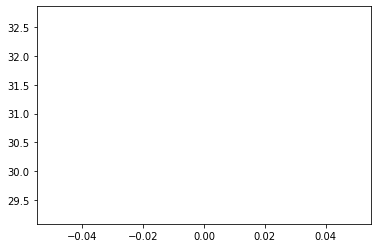

      0 average loss: 23.222585678100586 lr: 0.01
      50 average loss: 28.223608989341585 lr: 0.01
      100 average loss: 28.45862832399878 lr: 0.01
      150 average loss: 28.491956660289638 lr: 0.01
      200 average loss: 28.505397322166026 lr: 0.01
      250 average loss: 28.377623387066965 lr: 0.01
      300 average loss: 28.305931256062962 lr: 0.01
      350 average loss: 28.39127543848804 lr: 0.01
      400 average loss: 28.480008627113858 lr: 0.01
      450 average loss: 28.484583708769467 lr: 0.01
      500 average loss: 28.507883395501477 lr: 0.01
      550 average loss: 28.54309437885042 lr: 0.01
      600 average loss: 28.53315925280782 lr: 0.01
      650 average loss: 28.49752495292511 lr: 0.01
      700 average loss: 28.489172792638758 lr: 0.01
      750 average loss: 28.4201114136433 lr: 0.01
      800 average loss: 28.402705343772706 lr: 0.01
      850 average loss: 28.368085583284515 lr: 0.01
      900 average loss: 28.370568754934972 lr: 0.01
      950 average loss

     0 average loss: 32.93068313598633 lr: 0.01
     50 average loss: 28.203241011675665 lr: 0.01
     100 average loss: 28.085220903453262 lr: 0.01
     150 average loss: 27.846879175956676 lr: 0.01
     200 average loss: 28.0431871556524 lr: 0.01
     250 average loss: 28.043205572789407 lr: 0.01
     300 average loss: 28.098556467861023 lr: 0.01



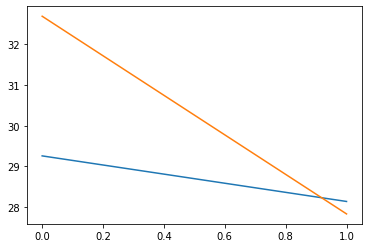

      0 average loss: 20.366043090820312 lr: 0.001
      50 average loss: 25.77532865486893 lr: 0.001
      100 average loss: 25.46456805314168 lr: 0.001
      150 average loss: 25.47895855935204 lr: 0.001
      200 average loss: 25.3939134588289 lr: 0.001
      250 average loss: 25.203968929579535 lr: 0.001
      300 average loss: 25.176187135056402 lr: 0.001
      350 average loss: 25.12297321113086 lr: 0.001
      400 average loss: 25.053498489303774 lr: 0.001
      450 average loss: 25.066993062089125 lr: 0.001
      500 average loss: 25.049785941422815 lr: 0.001
      550 average loss: 25.057412592339208 lr: 0.001
      600 average loss: 25.035279351740623 lr: 0.001
      650 average loss: 25.022200407154184 lr: 0.001
      700 average loss: 25.06684257300536 lr: 0.001
      750 average loss: 25.05970091381657 lr: 0.001
      800 average loss: 24.988280668984935 lr: 0.001
      850 average loss: 24.98034342307462 lr: 0.001
      900 average loss: 24.926806516573247 lr: 0.001
     

     0 average loss: 31.942657470703125 lr: 0.001
     50 average loss: 26.63403907476687 lr: 0.001
     100 average loss: 26.502270670220405 lr: 0.001
     150 average loss: 26.27912275049071 lr: 0.001
     200 average loss: 26.430979458253773 lr: 0.001
     250 average loss: 26.438070631597146 lr: 0.001
     300 average loss: 26.496295073499716 lr: 0.001



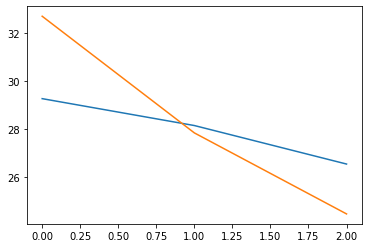

      0 average loss: 18.78879737854004 lr: 0.001
      50 average loss: 23.687190523334582 lr: 0.001
      100 average loss: 23.391215163882418 lr: 0.001
      150 average loss: 23.40969599793289 lr: 0.001
      200 average loss: 23.614295390114854 lr: 0.001
      250 average loss: 23.62062094411052 lr: 0.001
      300 average loss: 23.749874834206402 lr: 0.001
      350 average loss: 23.80152206475237 lr: 0.001
      400 average loss: 23.790222955166236 lr: 0.001
      450 average loss: 23.829158907719023 lr: 0.001
      500 average loss: 23.829259998070253 lr: 0.001
      550 average loss: 23.77000833985592 lr: 0.001
      600 average loss: 23.711412953457682 lr: 0.001
      650 average loss: 23.693364815777876 lr: 0.001
      700 average loss: 23.65921166075787 lr: 0.001
      750 average loss: 23.699289636827793 lr: 0.001
      800 average loss: 23.671074844627025 lr: 0.001
      850 average loss: 23.68685396129458 lr: 0.001
      900 average loss: 23.71338874042098 lr: 0.001
    

     0 average loss: 32.048622131347656 lr: 0.001
     50 average loss: 26.50974075466979 lr: 0.001
     100 average loss: 26.422258868075833 lr: 0.001
     150 average loss: 26.221091832546197 lr: 0.001
     200 average loss: 26.356252708245265 lr: 0.001
     250 average loss: 26.3660503934579 lr: 0.001
     300 average loss: 26.414573954585375 lr: 0.001



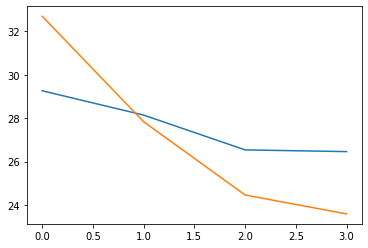

      0 average loss: 22.522260665893555 lr: 0.0001
      50 average loss: 22.652302274516984 lr: 0.0001
      100 average loss: 22.878827236666538 lr: 0.0001
      150 average loss: 22.76691501187963 lr: 0.0001
      200 average loss: 22.56806765504144 lr: 0.0001
      250 average loss: 22.516075643410243 lr: 0.0001
      300 average loss: 22.583245039778298 lr: 0.0001
      350 average loss: 22.561697973485014 lr: 0.0001
      400 average loss: 22.54579958119001 lr: 0.0001
      450 average loss: 22.487064283332916 lr: 0.0001
      500 average loss: 22.547812817815306 lr: 0.0001
      550 average loss: 22.553845206535886 lr: 0.0001
      600 average loss: 22.519605893660316 lr: 0.0001
      650 average loss: 22.61805319895943 lr: 0.0001
      700 average loss: 22.63141792204853 lr: 0.0001
      750 average loss: 22.63840630273527 lr: 0.0001
      800 average loss: 22.625891730728817 lr: 0.0001
      850 average loss: 22.62548180724703 lr: 0.0001
      900 average loss: 22.64188978806

     0 average loss: 31.660743713378906 lr: 0.0001
     50 average loss: 26.44273567199707 lr: 0.0001
     100 average loss: 26.338918723682365 lr: 0.0001
     150 average loss: 26.12269813335494 lr: 0.0001
     200 average loss: 26.27003663096261 lr: 0.0001
     250 average loss: 26.281269096283317 lr: 0.0001
     300 average loss: 26.33587333767913 lr: 0.0001



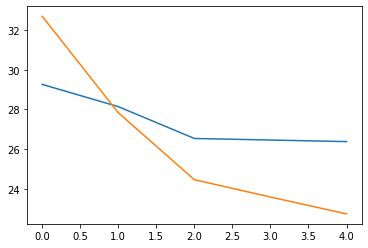

      0 average loss: 19.263547897338867 lr: 0.0001
      50 average loss: 23.298459595324946 lr: 0.0001
      100 average loss: 22.97742734097018 lr: 0.0001
      150 average loss: 23.009727932759468 lr: 0.0001
      200 average loss: 22.997521120517398 lr: 0.0001
      250 average loss: 22.827633101626688 lr: 0.0001
      300 average loss: 22.676506004460215 lr: 0.0001
      350 average loss: 22.704366539957835 lr: 0.0001
      400 average loss: 22.61673402191693 lr: 0.0001
      450 average loss: 22.521959410538415 lr: 0.0001
      500 average loss: 22.528351226014752 lr: 0.0001
      550 average loss: 22.530055618978437 lr: 0.0001
      600 average loss: 22.588238435259655 lr: 0.0001
      650 average loss: 22.57365407225904 lr: 0.0001
      700 average loss: 22.59939863338279 lr: 0.0001
      750 average loss: 22.58088687891647 lr: 0.0001
      800 average loss: 22.5415254407161 lr: 0.0001
      850 average loss: 22.520552583642893 lr: 0.0001
      900 average loss: 22.49777770703

     0 average loss: 31.793806076049805 lr: 0.0001
     50 average loss: 26.456875184003046 lr: 0.0001
     100 average loss: 26.361383456994993 lr: 0.0001
     150 average loss: 26.144583064199285 lr: 0.0001
     200 average loss: 26.292385993312248 lr: 0.0001
     250 average loss: 26.302518669827524 lr: 0.0001
     300 average loss: 26.360978256428364 lr: 0.0001



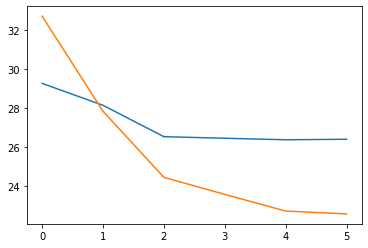

      0 average loss: 22.130516052246094 lr: 1e-05
      50 average loss: 22.998290791231042 lr: 1e-05
      100 average loss: 22.98306961814956 lr: 1e-05
      150 average loss: 22.665273988483758 lr: 1e-05
      200 average loss: 22.716219370637962 lr: 1e-05
      250 average loss: 22.61301180091037 lr: 1e-05
      300 average loss: 22.54633786591184 lr: 1e-05
      350 average loss: 22.499984064672738 lr: 1e-05
      400 average loss: 22.533659078831082 lr: 1e-05
      450 average loss: 22.55836134739302 lr: 1e-05
      500 average loss: 22.569626339895276 lr: 1e-05
      550 average loss: 22.61073295087865 lr: 1e-05
      600 average loss: 22.5815705554854 lr: 1e-05
      650 average loss: 22.598737353370275 lr: 1e-05
      700 average loss: 22.57191163905165 lr: 1e-05
      750 average loss: 22.61135902607963 lr: 1e-05
      800 average loss: 22.646185004606956 lr: 1e-05
      850 average loss: 22.64794444925775 lr: 1e-05
      900 average loss: 22.62670953265833 lr: 1e-05
      9

     0 average loss: 31.689117431640625 lr: 1e-05
     50 average loss: 26.450497496361827 lr: 1e-05
     100 average loss: 26.356902509632675 lr: 1e-05
     150 average loss: 26.147743907195842 lr: 1e-05
     200 average loss: 26.291348205870065 lr: 1e-05
     250 average loss: 26.30042849688891 lr: 1e-05
     300 average loss: 26.35541150102583 lr: 1e-05



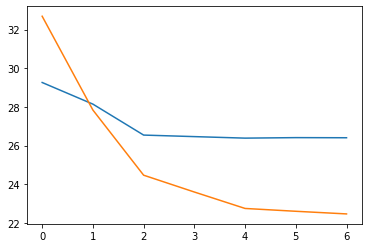

In [20]:
for epoch in tqdm (range (epochs)):
    train_one_epoch(train_dataloader, model, optimizer, train_loss_tracker)
    valid_one_epoch(valid_dataloader, model, valid_loss_tracker)
    scheduler.step()
    plt.plot (valid_loss_tracker)
    plt.plot (train_loss_tracker)
    plt.show()
    torch.save(model.state_dict(), model_path)

In [ ]:
model.load_state_dict (torch.load(model_path))
model.to(DEVICE)

## Bleu metric eval

In [155]:
from nltk.translate.bleu_score import corpus_bleu

def eval_bleu(target_df, predicated_sentences, ngram):
  list_of_references = []
  list_of_hypotheses = []
  for i in range(len(target_df)):
    image_fname = target_df.loc[i, 'image_fname']
    box = target_df.loc[i, 'box']
    similar_rows = target_df[ (target_df['image_fname'] == image_fname) & (target_df['box'] == box) ]
    refrences = [ sentence.split() for sentence in similar_rows['sentence'] ]
    hypotheses = predicated_sentences[i].split()
    list_of_references.append(refrences)
    list_of_hypotheses.append(hypotheses)
  weights = [1/ngram for _ in range(ngram)]
  return corpus_bleu(list_of_references, list_of_hypotheses, weights=weights)



decoded_sents = evalute (valid_dataloader, model)


In [156]:
import pandas as pd
target_file = 'dataset/dataset.valid.csv'

df = pd.read_csv(target_file)
ngram = 1
print("blue-{}: {}".format(ngram,eval_bleu(df, decoded_sents, ngram)))
ngram = 2
print("blue-{}: {}".format(ngram,eval_bleu(df, decoded_sents, ngram)))

blue-1: 0.3878243019610898
blue-2: 0.22568921192343158


## image captioning demo

ground truth: The horse being led by the girl in the white shirt.
decoded: the horse on the left


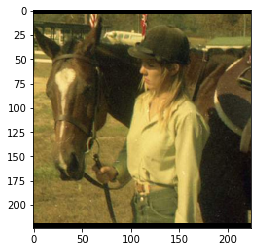

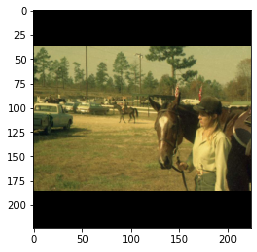

In [100]:
for i, batch in enumerate (valid_dataloader):
  original_datas, scaled_img_tensors, scaled_cropped_img_tensors, target_tensors = batch
  if i > 16:
      break
demo_one_data(model, scaled_img_tensors[0], scaled_cropped_img_tensors[0], original_datas[0])
torch.cuda.empty_cache()


ground truth: A man with an A on his Jersey.
decoded: a baseball player holding a bat .


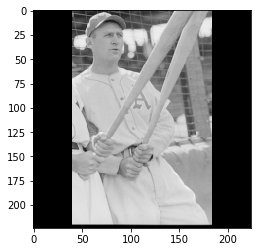

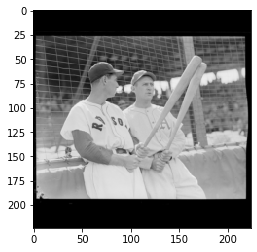

In [24]:
for batch in valid_dataloader:
  original_datas, scaled_img_tensors, scaled_cropped_img_tensors, target_tensors = batch
  break
demo_one_data(model, scaled_img_tensors[0], scaled_cropped_img_tensors[0], original_datas[0])
torch.cuda.empty_cache()


# Image Comprehenstion Training

## optimizer, scheduler

In [106]:
train_dataset.enable_comprehension_mode()
valid_dataset.enable_comprehension_mode()

In [107]:
model.load_state_dict (torch.load(model_path))
model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, dampening=0, weight_decay=5e-4, nesterov=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.5, last_epoch=-1)
lamda = 1.5

## fine tune functions

In [108]:
def train_fine_tune_one_epoch(dataloader, model, optimizer, loss_tracker):

    model.train()
    torch.cuda.empty_cache()
    
    loss_avg = 0
    n_batches = 0
    losses = []
    t = time.time()
    for i, batch in tqdm (enumerate (dataloader) , total = len (dataloader)):
        original_datas, scaled_img_tensors, scaled_cropped_img_tensors, tokenized_texts, neg_scaled_cropped_img_tensors = batch
        batch_size = len (scaled_img_tensors)
        optimizer.zero_grad()
        
        positive_log_prob = model([scaled_img_tensors, scaled_cropped_img_tensors, tokenized_texts])
        negative_log_prob = model([scaled_img_tensors, neg_scaled_cropped_img_tensors, tokenized_texts])
        J = - (positive_log_prob - lamda * torch.clamp(negative_log_prob - positive_log_prob, min=0))

        loss = J.sum()/batch_size        
        loss.backward()
        optimizer.step()

        
        loss_avg = (loss_avg * n_batches + loss.item() * batch_size) / (batch_size + n_batches)
        n_batches += batch_size
        if i% 100 == 0:
            print ("    " , i,"average loss:" , loss_avg, "lr:", get_lr(optimizer))
            losses.append (loss_avg)
#             loss_avg, n_batches = 0, 0
#             plt.plot (losses)
#             plt.show()
        del positive_log_prob, negative_log_prob, loss, J
        torch.cuda.empty_cache()
    loss_tracker.append (loss_avg)
        
def valid_fine_tune_one_epoch(dataloader, model, loss_tracker):

    model.eval()
    torch.cuda.empty_cache()
    
    loss_avg = 0
    n_batches = 0
    losses = []
    for i, batch in tqdm (enumerate (dataloader) , total = len (dataloader)):
        original_datas, scaled_img_tensors, scaled_cropped_img_tensors, tokenized_texts, neg_scaled_cropped_img_tensors = batch
        batch_size = len (scaled_img_tensors)
        with torch.no_grad():
            positive_log_prob = model([scaled_img_tensors, scaled_cropped_img_tensors, tokenized_texts])
            negative_log_prob = model([scaled_img_tensors, neg_scaled_cropped_img_tensors, tokenized_texts])
            J = - (positive_log_prob - lamda * torch.clamp(negative_log_prob - positive_log_prob, min=0))

            loss = J.sum()/batch_size
        loss_avg = (loss_avg * n_batches + loss.item() * batch_size) / (batch_size + n_batches)
        n_batches += batch_size
        if i% 100 == 0:
            print ("    " , i,"average loss:" , loss_avg, "lr:", get_lr(optimizer))
            losses.append (loss_avg)
#             loss_avg, n_batches = 0, 0
#             plt.plot (losses)
#             plt.show()
        del positive_log_prob, negative_log_prob, loss, J
        torch.cuda.empty_cache()    
    loss_tracker.append (loss_avg)


## fine tune loop

In [109]:
train_loss_tracker = []
valid_loss_tracker = []

In [ ]:
for epoch in tqdm (range (4)):
    train_fine_tune_one_epoch (train_dataloader, model, optimizer, train_loss_tracker)    
    valid_fine_tune_one_epoch (valid_dataloader, model, valid_loss_tracker)    
    scheduler.step()
    torch.save(model.state_dict(), "fine_tuned_model.pth")


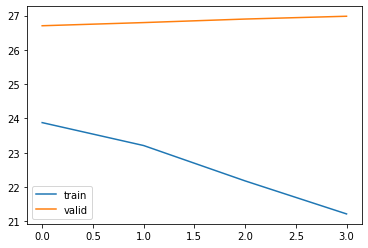

In [286]:
plt.plot (train_loss_tracker, label = 'train')
plt.plot (valid_loss_tracker, label = 'valid')
plt.legend()
plt.show()

In [57]:
model.load_state_dict(torch.load("fine_tuned_model.pth"))

<All keys matched successfully>

# Image Comprehnstion Model

In [110]:
class ImageComprehenserModel(nn.Module):
    def __init__(self, Captioner_model = None, vocab = None, dataset_regions = None):
        super(ImageComprehenserModel, self).__init__()
        self.captioner_model = Captioner_model.cpu()
        self.vocab = vocab
        self.rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        self.rcnn.eval()
        self.dataset_regions = dataset_regions
        
    def filter_candidates (self, candidates, scores, scores_th = 0.8 , top_k = 8):
        new_candidates = []
        for j , (box, score) in enumerate (zip (candidates, scores)):
            
            if score > scores_th:
                new_candidates.append (box)
            if j >= top_k:
                break
        if len (new_candidates) == 0:
            new_candidates = [candidates[0]]
        return new_candidates
        
    def forward (self, original_data_batch):
        boxes = []
        DEVICE = next (self.parameters()).device
        with torch.no_grad():
            for original_data in original_data_batch:
                original_img_tensor = original_data['original_img_tensor'].to(DEVICE)
                text = original_data['text']
                tokenized_text = ['<START>'] + tokenize([text])[0] + ['<END>']
                target_tensors = self.vocab.to_tensor(self.vocab.pad_sents([tokenized_text])).transpose (0,1)
                image_name = original_data['image_name']
                if self.dataset_regions is not None and image_name in self.dataset_regions.keys():
                    rcnn_output = self.dataset_regions[image_name]
#                     print ("cache")
                else:
                    rcnn_output = self.rcnn([original_img_tensor])[0]
                candidate_boxes = self.filter_candidates (rcnn_output['boxes'] , rcnn_output['scores'])
                
                boxes_and_scores = []
                pil_image = torchvision.transforms.ToPILImage(mode = 'RGB')(original_img_tensor.cpu())
                scaled_image = torchvision.transforms.ToTensor() (scale_and_pad (pil_image))
#                 plot_tensor (scaled_image)
                
                for i, box in enumerate (candidate_boxes[0:4]):
                    
                    x0,y0,x1,y1 = box
                    x0,y0,x1,y1 = x0.item(),y0.item(),x1.item(),y1.item()
                    box = [x0, y0, x1-x0, y1-y0]
                    
                    cropped_image = crop_image (pil_image, box)
                    
                    scaled_cropped_image = torchvision.transforms.ToTensor() (scale_and_pad (cropped_image))
                    

                    log_prob = self.captioner_model([scaled_image[None], scaled_cropped_image[None], target_tensors])
                 
                    boxes_and_scores.append ({"log_prob":log_prob, "box":box})
#                     print (rcnn_output['scores'][i] , log_prob)
#                 print (sorted(boxes_and_scores, key=lambda x: x['log_prob']))
                selected_box = max(boxes_and_scores, key=lambda x: x['log_prob'])['box']
                boxes.append (selected_box)
        return boxes    
            
            

In [111]:
comp_model = ImageComprehenserModel(model , vocab, valid_dataset.regions).cuda()

## Cmprehension Demo

(113.87, 83.6, 160.0, 338.74)
Woman in Green shirt talking with her co-worker
[[126.79127502441406, 86.68758392333984, 129.4955291748047, 342.46768951416016]]


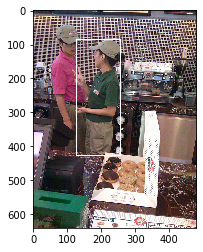

In [113]:
id = 12
print (original_datas[id]['box'])
print (original_datas[id]['text'])
print (comp_model([original_datas[id]]))
plot_tensor (plot_box_on_tensor (original_datas[id]['original_img_tensor'] , comp_model([original_datas[id]])[0]))
torch.cuda.empty_cache()

(256.61, 21.12, 124.0, 186.53)
Man on skateboard performing tricks - grinding a rail
[[255.48043823242188, 22.571054458618164, 130.64913940429688, 190.75856590270996]]


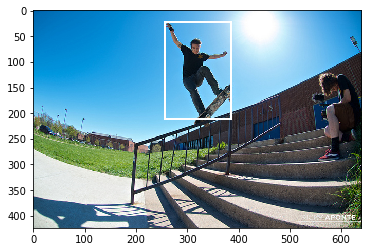

In [85]:
id = 15
print (original_datas[id]['box'])
print (original_datas[id]['text'])
print (comp_model([original_datas[id]]))
plot_tensor (plot_box_on_tensor (original_datas[id]['original_img_tensor'] , comp_model([original_datas[id]])[0]))
torch.cuda.empty_cache()

## Precision Evaluation

In [114]:
def comprehend_on_dataset(dataset, comp_model, max_limit = None):
    comp_model.eval()
    results = []
    for i, _data in tqdm (enumerate (dataset) , total = len (dataset) if max_limit is not None else max_limit):

      original_data = _data[0]
      boxes = comp_model([original_data])
      results += boxes
      torch.cuda.empty_cache()
      if max_limit is not None and i>= max_limit:
        break

    return results

predicted_boxes = comprehend_on_dataset (valid_dataset, comp_model)

In [116]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

def eval_precision(target_df, predicated_boxes):
  '''
  target_df: dataframe,
  predicated_boxes: list of boxes
  '''
  l = []
  for idx in range(len(target_df)):
    correct_box = [float(s) for s in target_df.loc[idx,'box'][1:-1].split()]
    pred_box = predicated_boxes[idx]
    x_0_box, y_0_box = correct_box[0], correct_box[1]
    x_1_box = x_0_box + correct_box[2]
    y_1_box = y_0_box + correct_box[3] 
    
    x_0_pred, y_0_pred = pred_box[0], pred_box[1]
    x_1_pred = x_0_pred + pred_box[2]
    y_1_pred = y_0_pred + pred_box[3]
    correct_box = [x_0_box, y_0_box, x_1_box, y_1_box]
    pred_box = [x_0_pred, y_0_pred, x_1_pred, y_1_box]
    IoU = bb_intersection_over_union(correct_box, pred_box)
    l.append(IoU)
  correct_prediction = [int(x>=0.5) for x in l]
  avg_IoU = sum(l) / len(l)
  p_1 = sum(correct_prediction) / len(correct_prediction)
  return p_1, avg_IoU

In [117]:
import pandas as pd
target_file = 'dataset/dataset.valid.csv'
# decoded_sents
df = pd.read_csv(target_file)

In [118]:
p_1, avg_IoU = eval_precision (df[0:len(predicted_boxes)],predicted_boxes)
print("Precision: ", p_1)
print("IoU: ", avg_IoU)

Precision:  0.533605720122574
IoU:  0.525950617201691


# Generating Test Files

## Captioning

In [159]:
import pandas as pd
target_file = 'dataset.test.gen.csv'
df = pd.read_csv(target_file)

original_datas = []
for idx in range(len(df)):
    test_box = [float(s) for s in df.loc[idx,'box'][1:-1].split()]
    
    original_datas.append ({"image_name":df.loc[idx,'image_fname'] , "box":test_box, "text":"hello world"})

In [160]:
test_dataset_captioning = ImageCaptioningDataset(original_datas, vocab = vocab, isValid = False)
test_dataset_captioning_dataloader = torch.utils.data.DataLoader(test_dataset_captioning, batch_size=16, num_workers = 0, shuffle=False , collate_fn = collate_fn, drop_last = False)

In [161]:
test_decoded_sents = evalute (test_dataset_captioning_dataloader, model)

In [163]:
df['sentence'] = test_decoded_sents
df.to_csv("dataset.test.gen1.csv", index = False)

In [164]:
with open('sentences.txt','w') as f:
    for sent in test_decoded_sents:
        f.write(sent+'\n')

a black couch with a pillow on it


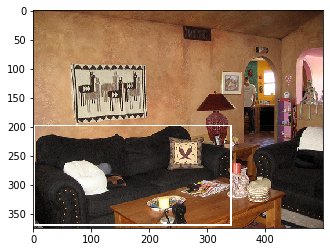

In [172]:
for i, _data in enumerate (test_dataset_captioning):
    original_data = _data[0]['original_img_tensor']
    box = _data[0]['box']
    print (test_decoded_sents[i])
    plot_tensor(plot_box_on_tensor (original_data, box))
    break

## Comprehension

In [132]:
import pandas as pd
target_file = 'dataset.test.comp.csv'
# decoded_sents
df = pd.read_csv(target_file)

original_datas = []
for idx in range(len(df)):
    test_box = [5.0, 5.0, 10.0, 15.0]
    original_datas.append ({"image_name":df.loc[idx,'image_fname'] , "box":test_box, "text":df.loc[idx,'sentence']})

In [134]:
test_dataset_comp = ImageCaptioningDataset(original_datas, vocab = vocab, isValid = False)

In [135]:
def comprehend_on_dataset(dataset, comp_model, max_limit = None):
    comp_model.eval()
    results = []
    for i, _data in tqdm (enumerate (dataset) , total = len (dataset) if max_limit is not None else max_limit):

      original_data = _data[0]
      boxes = comp_model([original_data])
      results += boxes
      torch.cuda.empty_cache()
      if max_limit is not None and i>= max_limit:
        break

    return results

predicted_boxes = comprehend_on_dataset (test_dataset_comp, comp_model)

C:\Users\MMWI\Anaconda3\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [139]:
boxs_string = []

with open('boxes.txt','w') as f:
    for box in predicted_boxes:
        x, y, w, h = box
        f.write("{}, {}, {}, {}".format (int (x), int(y) , int (w), int (h)) +'\n')
        boxs_string.append ("[{} {} {} {}]".format (int (x), int(y) , int (w), int (h)))

In [140]:
df['box'] = boxs_string
df.to_csv("dataset.test.comp1.csv", index = False)

A glass of water is sitting on the table.


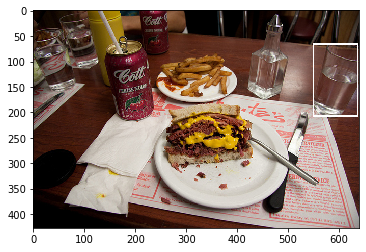

In [169]:
for i, _data in enumerate (test_dataset_comp):
    original_data = _data[0]['original_img_tensor']
    print (_data[0]['text'])
    plot_tensor(plot_box_on_tensor (original_data, predicted_boxes[i]))
    break